# Install reqs

In [ ]:
!pip install -q transformers datasets sentencepiece

In [ ]:
!pip install -q pytorch-lightning wandb

# Load Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# EDA

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

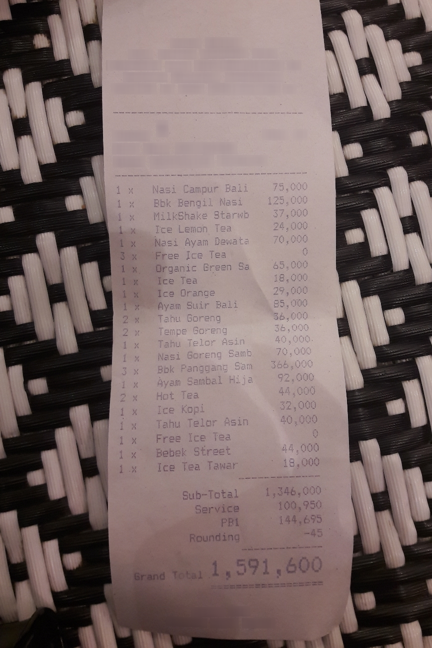

{
    "gt_parse": {
        "menu": [
            {
                "nm": "Nasi Campur Bali",
                "cnt": "1 x",
                "price": "75,000"
            },
            {
                "nm": "Bbk Bengil Nasi",
                "cnt": "1 x",
                "price": "125,000"
            },
            {
                "nm": "MilkShake Starwb",
                "cnt": "1 x",
                "price": "37,000"
            },
            {
                "nm": "Ice Lemon Tea",
                "cnt": "1 x",
                "price": "24,000"
            },
            {
                "nm": "Nasi Ayam Dewata",
                "cnt": "1 x",
                "price": "70,000"
            },
            {
                "nm": "Free Ice Tea",
                "cnt": "3 x",
                "price": "0"
            },
            {
                "nm": "Organic Green Sa",
                "cnt": "1 x",
                "price": "65,000"
            },
            {
               

In [ ]:
example = dataset['train'][0]
image = example['image']
width, height = image.size
display(image.resize((int(width*0.5), int(height*0.5))))

# liat ground truth nya
ground_truth = example['ground_truth']

import ast
ground_truth_parsed = ast.literal_eval(ground_truth)

import json
print(json.dumps(ground_truth_parsed, indent=4))


# Load Model & Processor

In [ ]:
from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 1024

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

# processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
# model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

processor = DonutProcessor.from_pretrained("kittyofheaven/donut_buat_fp_cord")
model = VisionEncoderDecoderModel.from_pretrained("kittyofheaven/donut_buat_fp_cord")

The image processor of type `DonutImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/483 [00:00<?, ?it/s]

In [ ]:
# # FREEZE PARAMETER HANYA PAKE YANG DI AKHIR, sesuai saran pak Hidayat

# # freeze semua
# for p in model.parameters():
#     p.requires_grad = False

# # UNFREEZE: decoder last K layers + lm_head
# K = 1  # coba 1-4, makin besar makin "bebas" tapi risiko overfit naik

# # Bart-like decoder biasanya ada di: model.decoder.model.decoder.layers
# for p in model.decoder.model.decoder.layers[-K:].parameters():
#     p.requires_grad = True

# # output head (penting)
# for p in model.decoder.lm_head.parameters():
#     p.requires_grad = True

# # final layernorm decoder
# if hasattr(model.decoder.model, "final_logits_bias"):
#     pass
# if hasattr(model.decoder.model.decoder, "layernorm_embedding"):
#     for p in model.decoder.model.decoder.layernorm_embedding.parameters():
#         p.requires_grad = True


In [ ]:
# freeze semua
for p in model.parameters():
    p.requires_grad = False

# unfreeze lm_head
for p in model.decoder.lm_head.parameters():
    p.requires_grad = True

# unfreeze token embedding (coba beberapa kemungkinan path)
if hasattr(model.decoder.model, "model") and hasattr(model.decoder.model.model, "shared"):
    # kasus umum: MBartModel punya shared embedding
    for p in model.decoder.model.model.shared.parameters():
        p.requires_grad = True
elif hasattr(model.decoder.model, "model") and hasattr(model.decoder.model.model, "decoder") and hasattr(model.decoder.model.model.decoder, "embed_tokens"):
    # alternatif: embed_tokens
    for p in model.decoder.model.model.decoder.embed_tokens.parameters():
        p.requires_grad = True
elif hasattr(model.decoder.model, "decoder") and hasattr(model.decoder.model.decoder, "embed_tokens"):
    # alternatif lain (tergantung wrapper)
    for p in model.decoder.model.decoder.embed_tokens.parameters():
        p.requires_grad = True
else:
    print("⚠️ Gagal menemukan token embedding path. Coba print(model.decoder) untuk cek struktur.")


In [ ]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print("Trainable:", trainable, " / Total:", total)


Trainable: 58961920  / Total: 201908344


# Create PYTORCH Datasets

In [ ]:
import re

def strip_punct_number(x):
    # ubah "Rp 12.500,00" -> "1250000" (hanya digit)
    if x is None:
        return x
    s = str(x)
    return re.sub(r"[^\d]", "", s)


In [ ]:
# import json
# import random
# from typing import Any, List, Tuple

# import torch
# from torch.utils.data import Dataset

# added_tokens = []

# class DonutDataset(Dataset):
#     """
#     PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.

#     Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
#     and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).

#     Args:
#         dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
#         max_length: the max number of tokens for the target sequences
#         split: whether to load "train", "validation" or "test" split
#         ignore_id: ignore_index for torch.nn.CrossEntropyLoss
#         task_start_token: the special token to be fed to the decoder to conduct the target task
#         prompt_end_token: the special token at the end of the sequences
#         sort_json_key: whether or not to sort the JSON keys
#     """

#     def __init__(
#         self,
#         dataset_name_or_path: str,
#         max_length: int,
#         split: str = "train",
#         ignore_id: int = -100,
#         task_start_token: str = "<s>",
#         prompt_end_token: str = None,
#         sort_json_key: bool = True,
#     ):
#         super().__init__()

#         self.max_length = max_length
#         self.split = split
#         self.ignore_id = ignore_id
#         self.task_start_token = task_start_token
#         self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
#         self.sort_json_key = sort_json_key

#         self.dataset = load_dataset(dataset_name_or_path, split=self.split)
#         self.dataset_length = len(self.dataset)

#         self.gt_token_sequences = []

#         for sample in self.dataset:
#           ground_truth = json.loads(sample["ground_truth"])

#           if "gt_parses" in ground_truth:
#               gt_jsons = ground_truth["gt_parses"]
#           else:
#               gt_jsons = [ground_truth["gt_parse"]]

#           # ✅ cleaning DI SINI
#           gt_jsons = [self.clean_prices_in_gt(gt) for gt in gt_jsons]

#           self.gt_token_sequences.append(
#               [
#                   self.json2token(
#                       gt_json,
#                       update_special_tokens_for_json_key=self.split == "train",
#                       sort_json_key=self.sort_json_key,
#                   )
#                   + processor.tokenizer.eos_token
#                   for gt_json in gt_jsons
#               ]
#           )


#         self.add_tokens([self.task_start_token, self.prompt_end_token])
#         self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

#     def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
#         """
#         Convert an ordered JSON object into a token sequence
#         """
#         if type(obj) == dict:
#             if len(obj) == 1 and "text_sequence" in obj:
#                 return obj["text_sequence"]
#             else:
#                 output = ""
#                 if sort_json_key:
#                     keys = sorted(obj.keys(), reverse=True)
#                 else:
#                     keys = obj.keys()
#                 for k in keys:
#                     if update_special_tokens_for_json_key:
#                         self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
#                     output += (
#                         fr"<s_{k}>"
#                         + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
#                         + fr"</s_{k}>"
#                     )
#                 return output
#         elif type(obj) == list:
#             return r"<sep/>".join(
#                 [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
#             )
#         else:
#             obj = str(obj)
#             if f"<{obj}/>" in added_tokens:
#                 obj = f"<{obj}/>"  # for categorical special tokens
#             return obj

#     def add_tokens(self, list_of_tokens: List[str]):
#         """
#         Add special tokens to tokenizer and resize the token embeddings of the decoder
#         """
#         newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
#         if newly_added_num > 0:
#             model.decoder.resize_token_embeddings(len(processor.tokenizer))
#             added_tokens.extend(list_of_tokens)

#     def __len__(self) -> int:
#         return self.dataset_length

#     def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         """
#         Load image from image_path of given dataset_path and convert into input_tensor and labels
#         Convert gt data into input_ids (tokenized string)
#         Returns:
#             input_tensor : preprocessed image
#             input_ids : tokenized gt_data
#             labels : masked labels (model doesn't need to predict prompt and pad token)
#         """
#         sample = self.dataset[idx]

#         # inputs
#         pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
#         pixel_values = pixel_values.squeeze()

#         # targets
#         target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
#         input_ids = processor.tokenizer(
#             target_sequence,
#             add_special_tokens=False,
#             max_length=self.max_length,
#             padding="max_length",
#             truncation=True,
#             return_tensors="pt",
#         )["input_ids"].squeeze(0)

#         labels = input_ids.clone()
#         labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
#         # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
#         return pixel_values, labels, target_sequence

#     def clean_prices_in_gt(self, obj):
#         """
#         Recursively clean price-like fields by removing punctuation.
#         Heuristic: keys containing 'price', 'total', 'subtotal', 'amount' will be digit-only.
#         """
#         if isinstance(obj, dict):
#             new_obj = {}
#             for k, v in obj.items():
#                 lk = str(k).lower()

#                 if any(x in lk for x in ["price", "total", "subtotal", "amount"]):
#                     # kalau nilainya dict/list, tetap rekursif; kalau scalar, bersihin jadi digit-only
#                     if isinstance(v, (dict, list)):
#                         new_obj[k] = self.clean_prices_in_gt(v)
#                     else:
#                         new_obj[k] = strip_punct_number(v)
#                 else:
#                     new_obj[k] = self.clean_prices_in_gt(v)
#             return new_obj

#         if isinstance(obj, list):
#             return [self.clean_prices_in_gt(x) for x in obj]

#         return obj

In [ ]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut with optional image augmentation (applied before processor -> tensor).
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
        augment=None,  # ✅ NEW
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key
        self.augment = augment  # ✅ NEW

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []

        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])

            if "gt_parses" in ground_truth:
                gt_jsons = ground_truth["gt_parses"]
            else:
                gt_jsons = [ground_truth["gt_parse"]]

            # ✅ cleaning DI SINI
            # gt_jsons = [self.clean_prices_in_gt(gt) for gt in gt_jsons]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                keys = sorted(obj.keys(), reverse=True) if sort_json_key else obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join([self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj])
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int):
        sample = self.dataset[idx]

        # ✅ get PIL image
        image = sample["image"].convert("RGB")

        # ✅ AUGMENT BEFORE TENSOR
        # Hanya untuk train split (biar val/test bersih), tapi tetap allow kalau kamu set manual
        if self.augment is not None and self.split == "train":
            img_np = np.array(image)
            img_np = self.augment(image=img_np)["image"]
            image = Image.fromarray(img_np).convert("RGB")

        # inputs -> tensor
        pixel_values = processor(
            image,
            random_padding=self.split == "train",
            return_tensors="pt"
        ).pixel_values.squeeze(0)  # [C,H,W]

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id

        return pixel_values, labels, target_sequence

    def clean_prices_in_gt(self, obj):
        if isinstance(obj, dict):
            new_obj = {}
            for k, v in obj.items():
                lk = str(k).lower()
                if any(x in lk for x in ["price", "total", "subtotal", "amount"]):
                    if isinstance(v, (dict, list)):
                        new_obj[k] = self.clean_prices_in_gt(v)
                    else:
                        new_obj[k] = strip_punct_number(v)
                else:
                    new_obj[k] = self.clean_prices_in_gt(v)
            return new_obj

        if isinstance(obj, list):
            return [self.clean_prices_in_gt(x) for x in obj]

        return obj

In [ ]:
# processor.image_processor.size = image_size[::-1] # should be (width, height)
# processor.image_processor.do_align_long_axis = False

# train_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
#                              split="train", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
#                              sort_json_key=False, # cord dataset is preprocessed, so no need for this
#                              )

# val_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
#                              split="validation", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
#                              sort_json_key=False, # cord dataset is preprocessed, so no need for this
#                              )

import albumentations as A
train_aug = A.Compose([
    # awal
    A.Rotate(limit=15, p=0.5, border_mode=0, value=255),      # background putih
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),

    # tambahan (receipt-friendly)
    A.ShiftScaleRotate(
        shift_limit=0.02, scale_limit=0.10, rotate_limit=4,
        border_mode=0, value=255, p=0.6
    ),
    A.Perspective(
        scale=(0.02, 0.07), fit_output=True,
        pad_mode=0, pad_val=255, p=0.35
    ),
    A.ImageCompression(quality_lower=55, quality_upper=92, p=0.45),
    A.GaussNoise(var_limit=(5.0, 25.0), p=0.30),
    A.MotionBlur(blur_limit=3, p=0.15),
])


processor.image_processor.size = image_size[::-1]
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset(
    "naver-clova-ix/cord-v2",
    max_length=max_length,
    split="train",
    task_start_token="<s_cord-v2>",
    prompt_end_token="<s_cord-v2>",
    sort_json_key=False,
    augment=train_aug,          # ✅ aktifkan AUG
)

val_dataset = DonutDataset(
    "naver-clova-ix/cord-v2",
    max_length=max_length,
    split="validation",
    task_start_token="<s_cord-v2>",
    prompt_end_token="<s_cord-v2>",
    sort_json_key=False,
    augment=None,               # ✅ no AUG
)

/tmp/ipython-input-3614475985.py:17: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=15, p=0.5, border_mode=0, value=255),      # background putih
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3614475985.py:22: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-3614475985.py:26: UserWarning: Argument(s) 'pad_mode, pad_val' are not valid for transform Perspective
  A.Perspective(
/tmp/ipython-input-3614475985.py:30: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=55, quality_upper=92, p=0.45),
/tmp/ipython-input-3614475985.py:31: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNo

In [ ]:
print(added_tokens)
len(added_tokens)


print("Number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens + special tokens:", len(processor.tokenizer))

[]
Number of tokens: 57522
Number of tokens + special tokens: 57580


cek data lagi

In [ ]:
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

Train size: 800
Val size: 100


In [ ]:
# cek augmentasi sudah jalan atau engga
pv1, _, _ = train_dataset[0]
pv2, _, _ = train_dataset[0]
print(torch.mean(torch.abs(pv1 - pv2)).item())


Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.


0.1732218712568283


In [ ]:
pixel_values, labels, target_sequence = train_dataset[0]

print(pixel_values.shape)

torch.Size([3, 960, 1280])


In [ ]:
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_menu>
<s_nm>
Nasi
Camp
ur
Bali
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_price>
7
5,000
</s_price>
<sep/>
<s_nm>
B
b
k
Ben
gil
Nasi
</s_nm>
<s_cnt>
1
x
</s_cnt>
<s_price>
12


In [ ]:
# let's check the corresponding target sequence, as a string
print(target_sequence)

<s_menu><s_nm>Nasi Campur Bali</s_nm><s_cnt>1 x</s_cnt><s_price>75,000</s_price><sep/><s_nm>Bbk Bengil Nasi</s_nm><s_cnt>1 x</s_cnt><s_price>125,000</s_price><sep/><s_nm>MilkShake Starwb</s_nm><s_cnt>1 x</s_cnt><s_price>37,000</s_price><sep/><s_nm>Ice Lemon Tea</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><sep/><s_nm>Nasi Ayam Dewata</s_nm><s_cnt>1 x</s_cnt><s_price>70,000</s_price><sep/><s_nm>Free Ice Tea</s_nm><s_cnt>3 x</s_cnt><s_price>0</s_price><sep/><s_nm>Organic Green Sa</s_nm><s_cnt>1 x</s_cnt><s_price>65,000</s_price><sep/><s_nm>Ice Tea</s_nm><s_cnt>1 x</s_cnt><s_price>18,000</s_price><sep/><s_nm>Ice Orange</s_nm><s_cnt>1 x</s_cnt><s_price>29,000</s_price><sep/><s_nm>Ayam Suir Bali</s_nm><s_cnt>1 x</s_cnt><s_price>85,000</s_price><sep/><s_nm>Tahu Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tempe Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tahu Telor Asin</s_nm><s_cnt>1 x</s_cnt><s_price>40,000.</s_price><sep/><s_nm>Nasi Goren

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_cord-v2>'])[0]

In [ ]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_cord-v2>


# Dataloaders

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

cek batch nya

In [ ]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([4, 3, 960, 1280])


In [ ]:
for id in labels[0].tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_menu>
<s_nm>
T
AKE
OUT
(1)
:
<sep/>
Viet
La
tte
</s_nm>
<s_cnt>
1
</s_cnt>
<s_price>
19
.000
</s_price>
<s_sub>
<s_nm>
+
S
</s_nm>
<sep/>
<s_nm>
+
I
ce
</s_nm>


In [ ]:
print(len(train_dataset))
print(len(val_dataset))

800
100


In [ ]:
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([4, 3, 960, 1280])


In [ ]:
print(target_sequences[0])

<s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total></s>


# Lightning Module

In [ ]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR
from transformers import get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)

        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
      # optimizer = torch.optim.AdamW(self.parameters(), lr=self.config["lr"])

      # yg ini biar ada freezenya
      optimizer = torch.optim.AdamW(
          filter(lambda p: p.requires_grad, self.parameters()),
          lr=self.config["lr"]
      )

      steps_per_epoch = len(self.train_dataloader())
      total_steps = steps_per_epoch * self.config["max_epochs"]
      warmup_steps = self.config["warmup_steps"]

      scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=warmup_steps,
          num_training_steps=total_steps,
      )

      return {
          "optimizer": optimizer,
          "lr_scheduler": {
              "scheduler": scheduler,
              "interval": "step"
          }
      }

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

# TRAINNNN

In [ ]:
config = {"max_epochs":30,
          "val_check_interval":1.0, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5, #1e-4, 5e-5, 3e-5
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [ ]:
!hf auth login

User is already logged in.


In [ ]:
!hf auth whoami

user:  kittyofheaven


In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

name = "donut_fp_v8.8"
wandb_logger = WandbLogger(project="Donut", name=name)

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("kittyofheaven/donut_buat_fp_cord",
                                    commit_message=f"Training in progress, {name} epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("kittyofheaven/donut_buat_fp_cord",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("kittyofheaven/donut_buat_fp_cord",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=5, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](h

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type                      ┃ Params ┃ Mode ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━┩
│ 0 │ model │ VisionEncoderDecoderModel │  201 M │ eval │     0 │
└───┴───────┴───────────────────────────┴────────┴──────┴───────┘

Trainable params: 59.0 M                                                                                           
Non-trainable params: 142 M                                                                                        
Total params: 201 M                                                                                                
Total estimated model params size (MB): 807                                                                        
Modules in train mode: 0                                                                                           
Modules in eval mode: 484                                                                                          
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:534: Found 484 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Normed ED: 0.0

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

Prediction: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>9,000</s_changeprice><s_menuqty_cnt>1</s_menuqt
y_cnt></s_total>

Answer: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>:9,000</s_changeprice><s_menuqty_cnt>1</s_menuq
ty_cnt></s_total>

Normed ED: 0.002631578947368421

Prediction: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00XITEMs</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt></s_total>

Normed ED: 0.00205761316872428

Prediction: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>20,000</s_changeprice><s_menu
qty_cnt>1</s_menuqty_cnt></s_total>

Answer: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_tot
al>

Normed ED: 0.12452830188679245

Prediction: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Answer: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,500</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Normed ED: 0.001644736842105263

Prediction: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><s_sub><s_nm>chapsal twister 
donnut</s_nm><s_cnt>1</s_cnt><s_price>10,000</s_price><s_sub><s_nm>TOTAL</s_nm><s_cnt>2</s_cnt><s_price>22,000</s_p
rice></s_sub></s_menu><s_total><s_total_price>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice
>0</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Normed ED: 0.13194444444444445

Prediction: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_cnt>0</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><
s_tax_price>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_c
ashprice></s_total>

Answer: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><s_sub><s_nm>Top 
Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><s_tax_pr
ice>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_cashprice
></s_total>

Normed ED: 0.21509433962264152

Prediction: <s_menu><s_nm>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Soy 
Sauce F</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>0</s_tax_price></s_sub_t
otal><s_total><s_total_price>379,500</s_total_price></s_total>

Answer: <s_menu><s_nm>Gojek Chicken Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Gojek Chicken Soy Sauce 
F</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>34,500</s_tax_price></s_
sub_total><s_total><s_total_price>379,500</s_total_price></s_total>

Normed ED: 0.21269296740994853

Prediction: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16,363</s_price></s_menu><s_sub_total><s_subtot
al_price>16,363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtot
al_price>16.363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.006430868167202572

Prediction: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Thai Iced 
T.x.</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total>
<s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_
total>

Answer: <s_menu><s_nm>Thai Iced T. 
.x1</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><
s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_t
otal>

Normed ED: 0.011450381679389313

Prediction: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Answer: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Honey 
Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_tota
l_price>26,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>4,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>Honey Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2 
X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>30,000</s_cas
hprice><s_changeprice>4,000</s_changeprice></s_total>

Normed ED: 0.004081632653061225

Prediction: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_emoneyprice>36,000</s_emoneyprice></
s_total>

Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Normed ED: 0.04176334106728538

Prediction: <s_menu><s_nm>Enting2 Dua Bandeng Ori 
01069</s_nm><s_unitprice>31.000</s_unitprice><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm>TAHU PAKSO Grg 
Ayam VC 
[biji</s_nm><s_unitprice>68.000</s_unitprice><s_cnt>1</s_cnt><s_price>68.000</s_price></s_menu><s_sub_total><s_subt
otal_price>99.000</s_subtotal_price></s_sub_total><s_total><s_total_price>99.000</s_total_price><s_creditcardprice>
99.000</s_creditcardprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Enting2 Dua Bandeng 
Ori</s_nm><s_num>01069</s_num><s_unitprice>31.000</s_unitprice><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm
>TAHU BAKSO Grg Ayam VC 
[biji</s_nm><s_num>07165</s_num><s_unitprice>6.800</s_unitprice><s_cnt>10</s_cnt><s_price>68.000</s_price></s_menu>
<s_total><s_total_price>99.000</s_total_price><s_creditcardprice>99.000</s_creditcardprice><s_menutype_cnt>2</s_men
utype_cnt><s_menuqty_cnt>11</s_menuqty_cnt></s_total>

Normed ED: 0.2538293216630197

Prediction: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>HAZELNUT CHOCO III (R)</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL ( R )</s_nm><s_price>4,000</s_price><sep/><s_nm>HAZELNUT CHOCO
III (R)</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_
total><s_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</
s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL
(R)</s_nm><s_price>4,000</s_price></s_sub><sep/><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</s_menuqt
y_cnt></s_total>

Normed ED: 0.05393258426966292

Prediction: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><s_sub><s_nm>BREAD * CHEE 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUBTOTAL</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price></s_sub></s_menu><s
_sub_total><s_subtotal_price>170,000</s_subtotal_price></s_total>

Answer: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><s_sub><s_nm>BREAD N 
CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SCSC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>154,545</s_subtotal_price><s_tax_price>1
5,455</s_tax_price></s_sub_total><s_total><s_total_price>170,000</s_total_price></s_total>

Normed ED: 0.11068702290076336

Prediction: <s_menu><s_nm>CF Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHAROE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm><FC Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHARGE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Normed ED: 0.007334963325183374

Prediction: <s_menu><s_nm>Choco 
Cheese</s_nm><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice><s_price>13,636</s_price></s_menu><s_sub_tota
l><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159</s_tax_p
rice></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total>

Answer: <s_menu><s_nm>Choco 
Cheese</s_nm><s_unitprice>13,636</s_unitprice><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice></s_menu><s_
sub_total><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159<
/s_tax_price></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total
>

Normed ED: 0.14754098360655737

Pushing model to the hub, epoch 0

README.md: 0.00B [00:00, ?B/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...sxew3qi/model.safetensors:   0%|          | 1.29MB /  809MB            

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>9,000</s_changeprice><s_menuqty_cnt>1</s_menuqt
y_cnt></s_total>

Answer: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>:9,000</s_changeprice><s_menuqty_cnt>1</s_menuq
ty_cnt></s_total>

Normed ED: 0.002631578947368421

Prediction: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00XITEMs</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt></s_total>

Normed ED: 0.00205761316872428

Prediction: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>20,000</s_changeprice><s_menu
qty_cnt>1</s_menuqty_cnt></s_total>

Answer: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_tot
al>

Normed ED: 0.12452830188679245

Prediction: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Answer: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,500</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Normed ED: 0.001644736842105263

Prediction: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Answer: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_cnt>0</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><
s_tax_price>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_c
ashprice></s_total>

Answer: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><s_sub><s_nm>Top 
Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><s_tax_pr
ice>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_cashprice
></s_total>

Normed ED: 0.11563169164882227

Prediction: <s_menu><s_nm>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Soy 
Sauce F</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>0</s_tax_price></s_sub_t
otal><s_total><s_total_price>379,500</s_total_price></s_total>

Answer: <s_menu><s_nm>Gojek Chicken Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Gojek Chicken Soy Sauce 
F</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>34,500</s_tax_price></s_
sub_total><s_total><s_total_price>379,500</s_total_price></s_total>

Normed ED: 0.21269296740994853

Prediction: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16,363</s_price></s_menu><s_sub_total><s_subtot
al_price>16,363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtot
al_price>16.363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.006430868167202572

Prediction: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Thai Iced 
T.x.</s_nm><s_cnt>1</s_cnt><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>Thai Iced T. 
.x1</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><
s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_t
otal>

Normed ED: 0.06159420289855073

Prediction: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Answer: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Honey 
Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_tota
l_price>26,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>4,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>Honey Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2 
X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>30,000</s_cas
hprice><s_changeprice>4,000</s_changeprice></s_total>

Normed ED: 0.004081632653061225

Prediction: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Enting2 Dua Bandeng Ori 
01069</s_nm><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm>TAHU PAKSO Grg Ayam VC 
[biji</s_nm><s_cnt>1</s_cnt><s_price>68.000</s_price></s_menu><s_sub_total><s_subtotal_price>68.000</s_subtotal_pri
ce><s_tax_price>6.800</s_tax_price></s_sub_total><s_total><s_total_price>99.000</s_total_price><s_creditcardprice>9
9.000</s_creditcardprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Enting2 Dua Bandeng 
Ori</s_nm><s_num>01069</s_num><s_unitprice>31.000</s_unitprice><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm
>TAHU BAKSO Grg Ayam VC 
[biji</s_nm><s_num>07165</s_num><s_unitprice>6.800</s_unitprice><s_cnt>10</s_cnt><s_price>68.000</s_price></s_menu>
<s_total><s_total_price>99.000</s_total_price><s_creditcardprice>99.000</s_creditcardprice><s_menutype_cnt>2</s_men
utype_cnt><s_menuqty_cnt>11</s_menuqty_cnt></s_total>

Normed ED: 0.38596491228070173

Prediction: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>HAZELNUT CHOCO III (R)</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL ( R )</s_nm><s_price>4,000</s_price><sep/><s_nm>HAZELNUT CHOCO
III ( R )</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_
total><s_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</
s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL
(R)</s_nm><s_price>4,000</s_price></s_sub><sep/><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</s_menuqt
y_cnt></s_total>

Normed ED: 0.058165548098434

Prediction: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><sep/><s_nm>BREAD M CHEESE
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUBTOTAL</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price></s_menu><s_sub_tot
al><s_subtotal_price>170,000</s_subtotal_price></s_total>

Answer: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><s_sub><s_nm>BREAD N 
CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SCSC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>154,545</s_subtotal_price><s_tax_price>1
5,455</s_tax_price></s_sub_total><s_total><s_total_price>170,000</s_total_price></s_total>

Normed ED: 0.11577608142493638

Prediction: <s_menu><s_nm>CF Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHAROE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm><FC Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHARGE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Normed ED: 0.007334963325183374

Prediction: <s_menu><s_nm>Choco 
Cheese</s_nm><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice><s_price>13,636</s_price></s_menu><s_sub_tota
l><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159</s_tax_p
rice></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total>

Answer: <s_menu><s_nm>Choco 
Cheese</s_nm><s_unitprice>13,636</s_unitprice><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice></s_menu><s_
sub_total><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159<
/s_tax_price></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total
>

Normed ED: 0.14754098360655737

Pushing model to the hub, epoch 1

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...r_9asmg/model.safetensors:   1%|          | 7.87MB /  809MB            

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>9,000</s_changeprice><s_menuqty_cnt>1</s_menuqt
y_cnt></s_total>

Answer: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>:9,000</s_changeprice><s_menuqty_cnt>1</s_menuq
ty_cnt></s_total>

Normed ED: 0.002631578947368421

Prediction: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00XITEMs</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt></s_total>

Normed ED: 0.00205761316872428

Prediction: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>20,000</s_changeprice><s_menu
qty_cnt>1</s_menuqty_cnt></s_total>

Answer: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_tot
al>

Normed ED: 0.12452830188679245

Prediction: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Answer: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,500</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Normed ED: 0.001644736842105263

Prediction: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Answer: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_cnt>0</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><
s_tax_price>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_c
ashprice></s_total>

Answer: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><s_sub><s_nm>Top 
Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><s_tax_pr
ice>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_cashprice
></s_total>

Normed ED: 0.11563169164882227

Prediction: <s_menu><s_nm>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Soy 
Sauce F</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>0</s_tax_price></s_sub_t
otal><s_total><s_total_price>379,500</s_total_price></s_total>

Answer: <s_menu><s_nm>Gojek Chicken Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Gojek Chicken Soy Sauce 
F</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>34,500</s_tax_price></s_
sub_total><s_total><s_total_price>379,500</s_total_price></s_total>

Normed ED: 0.21269296740994853

Prediction: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16,363</s_price></s_menu><s_sub_total><s_subtot
al_price>16,363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtot
al_price>16.363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.006430868167202572

Prediction: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Thai Iced 
T.x.</s_nm><s_cnt>1</s_cnt><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>Thai Iced T. 
.x1</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><
s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_t
otal>

Normed ED: 0.06159420289855073

Prediction: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Answer: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Honey 
Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_tota
l_price>26,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>4,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>Honey Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2 
X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>30,000</s_cas
hprice><s_changeprice>4,000</s_changeprice></s_total>

Normed ED: 0.004081632653061225

Prediction: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Enting2 Dua Bandeng Ori 
01069</s_nm><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm>TAHU BAKSO Grg Ayam VC 
[biji</s_nm><s_cnt>1</s_cnt><s_price>68.000</s_price></s_menu><s_sub_total><s_subtotal_price>68.000</s_subtotal_pri
ce><s_tax_price>6.800</s_tax_price></s_sub_total><s_total><s_total_price>99.000</s_total_price><s_creditcardprice>9
9.000</s_creditcardprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Enting2 Dua Bandeng 
Ori</s_nm><s_num>01069</s_num><s_unitprice>31.000</s_unitprice><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm
>TAHU BAKSO Grg Ayam VC 
[biji</s_nm><s_num>07165</s_num><s_unitprice>6.800</s_unitprice><s_cnt>10</s_cnt><s_price>68.000</s_price></s_menu>
<s_total><s_total_price>99.000</s_total_price><s_creditcardprice>99.000</s_creditcardprice><s_menutype_cnt>2</s_men
utype_cnt><s_menuqty_cnt>11</s_menuqty_cnt></s_total>

Normed ED: 0.38377192982456143

Prediction: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>HAZELNUT CHOCO III ( R )</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL ( R )</s_nm><s_price>4,000</s_price><sep/><s_nm>HAZELNUT CHOCO
III ( R )</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_
total><s_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</
s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL
(R)</s_nm><s_price>4,000</s_price></s_sub><sep/><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</s_menuqt
y_cnt></s_total>

Normed ED: 0.062360801781737196

Prediction: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><sep/><s_nm>BREAD M CHEESE
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUBTOTAL</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price></s_menu><s_sub_tot
al><s_subtotal_price>170,000</s_subtotal_price></s_total>

Answer: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><s_sub><s_nm>BREAD N 
CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SCSC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>154,545</s_subtotal_price><s_tax_price>1
5,455</s_tax_price></s_sub_total><s_total><s_total_price>170,000</s_total_price></s_total>

Normed ED: 0.11577608142493638

Prediction: <s_menu><s_nm>CF Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHAROE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm><FC Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHARGE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Normed ED: 0.007334963325183374

Prediction: <s_menu><s_nm>Choco 
Cheese</s_nm><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice><s_price>13,636</s_price></s_menu><s_sub_tota
l><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159</s_tax_p
rice></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total>

Answer: <s_menu><s_nm>Choco 
Cheese</s_nm><s_unitprice>13,636</s_unitprice><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice></s_menu><s_
sub_total><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159<
/s_tax_price></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total
>

Normed ED: 0.14754098360655737

Pushing model to the hub, epoch 2

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...j1_y57m/model.safetensors:   1%|          | 7.87MB /  809MB            

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>9,000</s_changeprice><s_menuqty_cnt>1</s_menuqt
y_cnt></s_total>

Answer: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>:9,000</s_changeprice><s_menuqty_cnt>1</s_menuq
ty_cnt></s_total>

Normed ED: 0.002631578947368421

Prediction: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00XITEMs</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt></s_total>

Normed ED: 0.00205761316872428

Prediction: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>20,000</s_changeprice><s_menu
qty_cnt>1</s_menuqty_cnt></s_total>

Answer: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_tot
al>

Normed ED: 0.12452830188679245

Prediction: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Answer: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,500</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Normed ED: 0.001644736842105263

Prediction: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Answer: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_cnt>0</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><
s_tax_price>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_c
ashprice></s_total>

Answer: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><s_sub><s_nm>Top 
Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><s_tax_pr
ice>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_cashprice
></s_total>

Normed ED: 0.11563169164882227

Prediction: <s_menu><s_nm>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Soy 
Sauce F</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>0</s_tax_price></s_sub_t
otal><s_total><s_total_price>379,500</s_total_price></s_total>

Answer: <s_menu><s_nm>Gojek Chicken Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Gojek Chicken Soy Sauce 
F</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>34,500</s_tax_price></s_
sub_total><s_total><s_total_price>379,500</s_total_price></s_total>

Normed ED: 0.21269296740994853

Prediction: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16,363</s_price></s_menu><s_sub_total><s_subtot
al_price>16,363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtot
al_price>16.363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.006430868167202572

Prediction: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Thai Iced 
T.x.</s_nm><s_cnt>1</s_cnt><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>Thai Iced T. 
.x1</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><
s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_t
otal>

Normed ED: 0.06159420289855073

Prediction: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Answer: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Honey 
Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_tota
l_price>26,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>4,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>Honey Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2 
X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>30,000</s_cas
hprice><s_changeprice>4,000</s_changeprice></s_total>

Normed ED: 0.004081632653061225

Prediction: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Enting2 Dua Bandeng Ori 
01069</s_nm><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm>TAHU BAKSO Grg Ayam VC 
[biji</s_nm><s_cnt>1</s_cnt><s_price>68.000</s_price></s_menu><s_sub_total><s_subtotal_price>68.000</s_subtotal_pri
ce><s_tax_price>6.800</s_tax_price></s_sub_total><s_total><s_total_price>99.000</s_total_price><s_creditcardprice>9
9.000</s_creditcardprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Enting2 Dua Bandeng 
Ori</s_nm><s_num>01069</s_num><s_unitprice>31.000</s_unitprice><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm
>TAHU BAKSO Grg Ayam VC 
[biji</s_nm><s_num>07165</s_num><s_unitprice>6.800</s_unitprice><s_cnt>10</s_cnt><s_price>68.000</s_price></s_menu>
<s_total><s_total_price>99.000</s_total_price><s_creditcardprice>99.000</s_creditcardprice><s_menutype_cnt>2</s_men
utype_cnt><s_menuqty_cnt>11</s_menuqty_cnt></s_total>

Normed ED: 0.38377192982456143

Prediction: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>HAZELNUT CHOCO III ( R )</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL ( R )</s_nm><s_price>4,000</s_price><sep/><s_nm>HAZELNUT CHOCO
III ( R )</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_
total><s_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</
s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL
(R)</s_nm><s_price>4,000</s_price></s_sub><sep/><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</s_menuqt
y_cnt></s_total>

Normed ED: 0.062360801781737196

Prediction: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><sep/><s_nm>BREAD M CHEESE
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUBTOTAL</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price></s_menu><s_sub_tot
al><s_subtotal_price>170,000</s_subtotal_price></s_total>

Answer: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><s_sub><s_nm>BREAD N 
CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SCSC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>154,545</s_subtotal_price><s_tax_price>1
5,455</s_tax_price></s_sub_total><s_total><s_total_price>170,000</s_total_price></s_total>

Normed ED: 0.11577608142493638

Prediction: <s_menu><s_nm>CF Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHAROE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm><FC Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHARGE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Normed ED: 0.007334963325183374

Prediction: <s_menu><s_nm>Choco 
Cheese</s_nm><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice><s_price>13,636</s_price></s_menu><s_sub_tota
l><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159</s_tax_p
rice></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total>

Answer: <s_menu><s_nm>Choco 
Cheese</s_nm><s_unitprice>13,636</s_unitprice><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice></s_menu><s_
sub_total><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159<
/s_tax_price></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total
>

Normed ED: 0.14754098360655737

Pushing model to the hub, epoch 3

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...hoqp8ku/model.safetensors:   1%|          | 7.87MB /  809MB            

Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG 
TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA 
TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cash
price>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>9,000</s_changeprice><s_menuqty_cnt>1</s_menuqt
y_cnt></s_total>

Answer: <s_menu><s_nm>BBQ 
Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_pric
e></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41
,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>:9,000</s_changeprice><s_menuqty_cnt>1</s_menuq
ty_cnt></s_total>

Normed ED: 0.002631578947368421

Prediction: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00XITEMs</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>TALAM 
UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,50
0</s_price><sep/><s_nm>MIKA 
KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_pri
ce>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cash
price><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt></s_total>

Normed ED: 0.00205761316872428

Prediction: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>ES KOPI 
SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_chang
eprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>20,000</s_changeprice><s_menu
qty_cnt>1</s_menuqty_cnt></s_total>

Answer: 
<s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total>
<s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_tot
al>

Normed ED: 0.12452830188679245

Prediction: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Answer: 
<s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>
5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s
_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_c
hangeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,500</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Answer: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO 
CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY 
ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>

Normed ED: 0.001644736842105263

Prediction: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Answer: <s_menu><s_nm>ELEPHANT READ 
BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister 
donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_p
rice>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_men
uqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Answer: <s_menu><s_nm>Nasi 
(MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price
></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Oreo</s_nm><s_cnt>0</s_cnt><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_cnt>0</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><
s_tax_price>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_c
ashprice></s_total>

Answer: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><s_sub><s_nm>Top 
Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top 
Banana</s_nm><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><s_tax_pr
ice>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_cashprice
></s_total>

Normed ED: 0.11563169164882227

Prediction: <s_menu><s_nm>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>Gojek Chicken</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Soy 
Sauce F</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>0</s_tax_price></s_sub_t
otal><s_total><s_total_price>379,500</s_total_price></s_total>

Answer: <s_menu><s_nm>Gojek Chicken Chilli Sauce 
H</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Gojek Chicken Soy Sauce 
F</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Gojek French 
Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_pr
ice><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>34,500</s_tax_price></s_
sub_total><s_total><s_total_price>379,500</s_total_price></s_total>

Normed ED: 0.21269296740994853

Prediction: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16,363</s_price></s_menu><s_sub_total><s_subtot
al_price>16,363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>THAI ICED TEA 
(L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtot
al_price>16.363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_t
otal_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.006430868167202572

Prediction: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha 
Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq 
Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_pri
ce><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000<
/s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL 
GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH 
MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Thai Iced 
T.x.</s_nm><s_cnt>1</s_cnt><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_pric
e></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_
changeprice></s_total>

Answer: <s_menu><s_nm>Thai Iced T. 
.x1</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><
s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_t
otal>

Normed ED: 0.06159420289855073

Prediction: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Answer: <s_menu><s_nm>VANILLA CHOCO HEART 
CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_cre
ditcardprice>180,000</s_creditcardprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>WHOLE WHEAT PAN 
BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cash
price>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Honey 
Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_tota
l_price>26,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>4,000</s_changeprice></s_total>

Answer: <s_menu><s_nm>Honey Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2 
X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>30,000</s_cas
hprice><s_changeprice>4,000</s_changeprice></s_total>

Normed ED: 0.004081632653061225

Prediction: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 
x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcard
price></s_total>

Normed ED: 0.0

Prediction: <s_menu><s_nm>Enting2 Dua Bandeng Ori 
01069</s_nm><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm>TAHU BAKSO Grg Ayam VC 
[biji</s_nm><s_cnt>1</s_cnt><s_price>68.000</s_price></s_menu><s_sub_total><s_subtotal_price>68.000</s_subtotal_pri
ce><s_tax_price>6.800</s_tax_price></s_sub_total><s_total><s_total_price>99.000</s_total_price><s_creditcardprice>9
9.000</s_creditcardprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Enting2 Dua Bandeng 
Ori</s_nm><s_num>01069</s_num><s_unitprice>31.000</s_unitprice><s_cnt>1</s_cnt><s_price>31.000</s_price><sep/><s_nm
>TAHU BAKSO Grg Ayam VC 
[biji</s_nm><s_num>07165</s_num><s_unitprice>6.800</s_unitprice><s_cnt>10</s_cnt><s_price>68.000</s_price></s_menu>
<s_total><s_total_price>99.000</s_total_price><s_creditcardprice>99.000</s_creditcardprice><s_menutype_cnt>2</s_men
utype_cnt><s_menuqty_cnt>11</s_menuqty_cnt></s_total>

Normed ED: 0.38377192982456143

Prediction: <s_menu><s_nm>Sate 
Pedang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>Sate 
Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cas
hprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>

Normed ED: 0.0049261083743842365

Prediction: <s_menu><s_nm>HAZELNUT CHOCO MT ( R )</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL ( R )</s_nm><s_price>4,000</s_price><sep/><s_nm>HAZELNUT CHOCO
MT ( R )</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_
total><s_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</
s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL
(R)</s_nm><s_price>4,000</s_price></s_sub><sep/><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 
x</s_cnt><s_price>24,000</s_price></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_total><s
_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</s_menuqt
y_cnt></s_total>

Normed ED: 0.049217002237136466

Prediction: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><sep/><s_nm>BREAD M CHEESE
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUBTOTAL</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price></s_menu><s_sub_tot
al><s_subtotal_price>170,000</s_subtotal_price></s_total>

Answer: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><s_sub><s_nm>BREAD N 
CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SCSC/P BBQ BEEF 
DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN 
SODA</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>154,545</s_subtotal_price><s_tax_price>1
5,455</s_tax_price></s_sub_total><s_total><s_total_price>170,000</s_total_price></s_total>

Normed ED: 0.11577608142493638

Prediction: <s_menu><s_nm>CF Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHAROE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Answer: <s_menu><s_nm><FC Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHARGE 
TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_
tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cas
hprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>

Normed ED: 0.007334963325183374

Prediction: <s_menu><s_nm>Choco 
Cheese</s_nm><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice><s_price>13,636</s_price></s_menu><s_sub_tota
l><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159</s_tax_p
rice></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total>

Answer: <s_menu><s_nm>Choco 
Cheese</s_nm><s_unitprice>13,636</s_unitprice><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice></s_menu><s_
sub_total><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159<
/s_tax_price></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total
>

Normed ED: 0.14754098360655737

Pushing model to the hub, epoch 4

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...wykxodb/model.safetensors:   1%|          | 7.87MB /  809MB            

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Pushing model to the hub after training

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...8v8_htf/model.safetensors:   5%|5         | 41.9MB /  809MB            

No files have been modified since last commit. Skipping to prevent empty commit.


In [ ]:
print("selesai!")

selesai!


# EVALUATION

In [1]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained(
    "kittyofheaven/donut_buat_fp_cord",
)

model = VisionEncoderDecoderModel.from_pretrained(
    "kittyofheaven/donut_buat_fp_cord",
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/483 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [2]:
!pip install -q donut-python

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 11.9 MB/s eta 0:00:00


In [3]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np

# --- Patch to fix ImportError with recent transformers versions ---
from transformers import PretrainedConfig
import transformers.modeling_utils
transformers.modeling_utils.PretrainedConfig = PretrainedConfig
# ----------------------------------------------------------------

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-b4aaeceff1d90e(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00004-7dbbe248962764(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00002-of-00004-688fe1305a55e5(…):   0%|          | 0.00/444M [00:00<?, ?B/s]

data/train-00003-of-00004-2d0cd200555ed7(…):   0%|          | 0.00/456M [00:00<?, ?B/s]

data/validation-00000-of-00001-cc3c5779f(…):   0%|          | 0.00/242M [00:00<?, ?B/s]

data/test-00000-of-00001-9c204eb3f4e1179(…):   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


{'accuracies': [np.float64(0.735632183908046), np.float64(1.0), np.float64(0.6404494382022472), np.float64(0.9647058823529412), np.float64(0.9857142857142858), np.float64(0.64), np.float64(1.0), np.float64(0.5526315789473684), np.float64(0.9387755102040817), np.float64(0.9375), np.float64(0.9848484848484849), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9611650485436893), np.float64(0.6695652173913044), np.float64(0.9555555555555556), np.float64(0.9384615384615385), np.float64(0.9886363636363636), np.float64(0.990909090909091), np.float64(1.0), np.float64(0.8491620111731844), np.float64(0.86), np.float64(1.0), np.float64(0.9651741293532339), np.float64(0.8427947598253275), np.float64(0.9876543209876543), np.float64(0.9838709677419355), np.float64(1.0), np.float64(0.7936507936507937), np.float64(0.975), np.float64(1.0), np.float64(1.0), np.float64(0.8160919540229885), np.float64(0.9675324675324676), np.float64(1.0), np.float64(0.78125), np.float64(0.9642857142857143),

In [4]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.9099505287626936


In [5]:
# Cell 1 - Collect latency (ms) per sample (E2E: preprocess + generate + decode + token2json)
import time
import numpy as np
import torch
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

latencies_ms = []
num_samples = len(dataset)

# optional: warmup biar GPU "stabil"
warmup_steps = min(10, num_samples)
for i in range(warmup_steps):
    sample = dataset[i]
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values.to(device)
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)

    with torch.inference_mode():
        _ = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

# timing loop
for idx, sample in tqdm(enumerate(dataset), total=num_samples):
    t0 = time.perf_counter()

    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values.to(device)
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)

    with torch.inference_mode():
        if device == "cuda":
            torch.cuda.synchronize()

        outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

        # include decoding + token2json in E2E
        seq = processor.batch_decode(outputs.sequences)[0]
        seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
        seq = re.sub(r"<.*?>", "", seq, count=1).strip()
        _ = processor.token2json(seq)

        if device == "cuda":
            torch.cuda.synchronize()

    t1 = time.perf_counter()
    latencies_ms.append((t1 - t0) * 1000.0)

latencies_ms = np.array(latencies_ms, dtype=np.float64)
print(f"Collected {len(latencies_ms)} latency samples. (ms)")

  0%|          | 0/100 [00:00<?, ?it/s]

Collected 100 latency samples. (ms)


In [7]:
# Cell 2 - Compute p50 / p90 / p99 + summary
import numpy as np
import wandb

if wandb.run is None:
    wandb.init(project="Donut", name="donut_fp_v8.8_p_evaluation", resume="allow")

p50 = float(np.percentile(latencies_ms, 50))
p90 = float(np.percentile(latencies_ms, 90))
p99 = float(np.percentile(latencies_ms, 99))

mean = float(np.mean(latencies_ms))
min_v = float(np.min(latencies_ms))
max_v = float(np.max(latencies_ms))

# throughput sederhana (docs/sec)
total_sec = float(np.sum(latencies_ms) / 1000.0)
throughput = float(len(latencies_ms) / total_sec) if total_sec > 0 else float("nan")

gpu_stats = {
    "count": int(len(latencies_ms)),
    "min_ms": min_v,
    "mean_ms": mean,
    "p50_ms": p50,
    "p90_ms": p90,
    "p99_ms": p99,
    "max_ms": max_v,
    "throughput_docs_per_sec": throughput
}

print(gpu_stats)

# Log to WandB with prefix
wandb.log({"gpu_" + k: v for k, v in gpu_stats.items()})

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hazelhandrata (kittyofheaven) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'count': 100, 'min_ms': 438.00128800012317, 'mean_ms': 684.2868909600224, 'p50_ms': 648.1992715000615, 'p90_ms': 888.4111747999441, 'p99_ms': 1305.2337444699976, 'max_ms': 1450.2765130000626, 'throughput_docs_per_sec': 1.461375357632596}


In [8]:
import json
print("p50 p90 p99 untuk model dengan GPU Tesla T4")
print(json.dumps({
    "count": int(len(latencies_ms)),
    "min_ms": min_v,
    "mean_ms": mean,
    "p50_ms": p50,
    "p90_ms": p90,
    "p99_ms": p99,
    "max_ms": max_v,
    "throughput_docs_per_sec": throughput,
}, indent=4))

p50 p90 p99 untuk model dengan GPU Tesla T4
{
    "count": 100,
    "min_ms": 438.00128800012317,
    "mean_ms": 684.2868909600224,
    "p50_ms": 648.1992715000615,
    "p90_ms": 888.4111747999441,
    "p99_ms": 1305.2337444699976,
    "max_ms": 1450.2765130000626,
    "throughput_docs_per_sec": 1.461375357632596
}


In [9]:
# Cell A — Benchmark latency endpoint /predict (resize to 1280x960, send image via multipart)
import time
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from datasets import load_dataset

# Ganti ini sesuai base URL server kamu
BASE_URL = "https://monkeylimitsbe.rtbconnect.space/"

# dataset sama seperti sebelumnya
dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

TARGET_SIZE = (1280, 960)  # (width, height) for PIL

latencies_ms = []
status_codes = []
ok_flags = []
errors = []

session = requests.Session()

# optional warmup (biar koneksi/session & server "hangat")
warmup_n = min(5, len(dataset))
for i in range(warmup_n):
    img = dataset[i]["image"].convert("RGB").resize(TARGET_SIZE, Image.BILINEAR)
    buf = BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    files = {"file": ("sample.png", buf, "image/png")}
    try:
        _ = session.post(f"{BASE_URL}/predict", files=files, timeout=60)
    except Exception:
        pass

# benchmark loop
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    img = sample["image"].convert("RGB").resize(TARGET_SIZE, Image.BILINEAR)

    buf = BytesIO()
    img.save(buf, format="PNG")   # kirim sebagai PNG (aman)
    buf.seek(0)

    files = {"file": ("sample.png", buf, "image/png")}

    t0 = time.perf_counter()
    try:
        resp = session.post(f"{BASE_URL}/predict", files=files, timeout=120)
        t1 = time.perf_counter()

        latency = (t1 - t0) * 1000.0
        latencies_ms.append(latency)
        status_codes.append(resp.status_code)

        # coba parse json response supaya tahu ok/false
        try:
            data = resp.json()
            ok_flags.append(bool(data.get("ok", False)))
            if resp.status_code != 200 or not data.get("ok", False):
                errors.append({"idx": idx, "status": resp.status_code, "body": data})
        except Exception:
            ok_flags.append(False)
            errors.append({"idx": idx, "status": resp.status_code, "body": resp.text[:500]})

    except Exception as e:
        t1 = time.perf_counter()
        latencies_ms.append((t1 - t0) * 1000.0)
        status_codes.append(-1)
        ok_flags.append(False)
        errors.append({"idx": idx, "status": -1, "error": str(e)})

latencies_ms = np.array(latencies_ms, dtype=np.float64)
print(f"Done. total={len(latencies_ms)} | success_ok={sum(ok_flags)} | fail={len(ok_flags)-sum(ok_flags)}")
print(f"Non-200 or ok=false samples captured: {len(errors)} (showing first 3)")
print(errors[:3])

  0%|          | 0/100 [00:00<?, ?it/s]

Done. total=100 | success_ok=100 | fail=0
Non-200 or ok=false samples captured: 0 (showing first 3)
[]


In [10]:
# Cell B — Hitung p50 / p90 / p99 + ringkasan
import numpy as np
import wandb

if wandb.run is None:
    wandb.init(project="Donut", name="donut_fp_v8.8_p_eval_cpu", resume="allow")

p50 = float(np.percentile(latencies_ms, 50))
p90 = float(np.percentile(latencies_ms, 90))
p99 = float(np.percentile(latencies_ms, 99))

mean = float(np.mean(latencies_ms))
min_v = float(np.min(latencies_ms))
max_v = float(np.max(latencies_ms))

# throughput (docs/sec) berdasarkan total latency sum
total_sec = float(np.sum(latencies_ms) / 1000.0)
throughput = float(len(latencies_ms) / total_sec) if total_sec > 0 else float("nan")

summary = {
    "count": int(len(latencies_ms)),
    "min_ms": min_v,
    "mean_ms": mean,
    "p50_ms": p50,
    "p90_ms": p90,
    "p99_ms": p99,
    "max_ms": max_v,
    "throughput_docs_per_sec": throughput,
    "http_status_counts": dict(zip(*np.unique(np.array(status_codes), return_counts=True))),
    "ok_true_count": int(np.sum(np.array(ok_flags, dtype=np.int32))),
    "ok_false_count": int(len(ok_flags) - np.sum(np.array(ok_flags, dtype=np.int32))),
}
print(summary)

# Log to WandB (excluding complex dict structures like http_status_counts for cleaner logging)
log_data = {k: v for k, v in summary.items() if k != "http_status_counts"}
wandb.log({"cpu_" + k: v for k, v in log_data.items()})

{'count': 100, 'min_ms': 10880.831734000367, 'mean_ms': 14302.302520839989, 'p50_ms': 13584.769454499907, 'p90_ms': 17365.099724999895, 'p99_ms': 24110.81875461976, 'max_ms': 27704.225874999793, 'throughput_docs_per_sec': 0.06991881192156946, 'http_status_counts': {np.int64(200): np.int64(100)}, 'ok_true_count': 100, 'ok_false_count': 0}


In [11]:
import json
import numpy as np

# convert http_status_counts keys dn values ke int biasa
fixed_status_counts = {
    int(k): int(v)
    for k, v in summary["http_status_counts"].items()
}

summary_fixed = {
    "count": int(summary["count"]),
    "min_ms": float(summary["min_ms"]),
    "mean_ms": float(summary["mean_ms"]),
    "p50_ms": float(summary["p50_ms"]),
    "p90_ms": float(summary["p90_ms"]),
    "p99_ms": float(summary["p99_ms"]),
    "max_ms": float(summary["max_ms"]),
    "throughput_docs_per_sec": float(summary["throughput_docs_per_sec"]),
    "http_status_counts": fixed_status_counts,
    "ok_true_count": int(summary["ok_true_count"]),
    "ok_false_count": int(summary["ok_false_count"]),
}

print("p50 p90 p99 untuk model di backend dengan CPU 13th Gen i5-1335U")
print(json.dumps(summary_fixed, indent=4))

p50 p90 p99 untuk model di backend dengan CPU 13th Gen i5-1335U
{
    "count": 100,
    "min_ms": 10880.831734000367,
    "mean_ms": 14302.302520839989,
    "p50_ms": 13584.769454499907,
    "p90_ms": 17365.099724999895,
    "p99_ms": 24110.81875461976,
    "max_ms": 27704.225874999793,
    "throughput_docs_per_sec": 0.06991881192156946,
    "http_status_counts": {
        "200": 100
    },
    "ok_true_count": 100,
    "ok_false_count": 0
}


In [12]:
# import re
# import json
# import torch
# from tqdm.auto import tqdm
# import numpy as np

# from transformers import PretrainedConfig
# import transformers.modeling_utils
# transformers.modeling_utils.PretrainedConfig = PretrainedConfig

# from donut import JSONParseEvaluator
# from datasets import load_dataset

# device = "cuda" if torch.cuda.is_available() else "cpu"

# model.eval()
# model.to(device)

# output_list = []
# accs = []

# dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")
# evaluator = JSONParseEvaluator()  # ✅ init sekali

# for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
#     # encoder inputs
#     pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values.to(device)

#     # decoder inputs
#     task_prompt = "<s_cord-v2>"
#     decoder_input_ids = processor.tokenizer(
#         task_prompt, add_special_tokens=False, return_tensors="pt"
#     ).input_ids.to(device)

#     # generate
#     outputs = model.generate(
#         pixel_values,
#         decoder_input_ids=decoder_input_ids,
#         max_length=model.decoder.config.max_position_embeddings,
#         early_stopping=True,
#         pad_token_id=processor.tokenizer.pad_token_id,
#         eos_token_id=processor.tokenizer.eos_token_id,
#         use_cache=True,
#         num_beams=1,
#         bad_words_ids=[[processor.tokenizer.unk_token_id]],
#         return_dict_in_generate=True,
#     )

#     # decode -> json
#     seq = processor.batch_decode(outputs.sequences)[0]
#     seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
#     seq = re.sub(r"<.*?>", "", seq, count=1).strip()
#     pred = processor.token2json(seq)

#     # ✅ ground truth (handle gt_parse / gt_parses)
#     gt_obj = json.loads(sample["ground_truth"])
#     gt = gt_obj["gt_parse"] if "gt_parse" in gt_obj else gt_obj["gt_parses"][0]

#     # ✅ CONSISTENT WITH TRAINING: clean prices on both
#     gt_clean = train_dataset.clean_prices_in_gt(gt)
#     pred_clean = train_dataset.clean_prices_in_gt(pred)

#     score = evaluator.cal_acc(pred_clean, gt_clean)

#     accs.append(score)
#     output_list.append(pred_clean)

# scores = {"accuracies": accs, "mean_accuracy": float(np.mean(accs))}
# print(scores, f"length : {len(accs)}")


In [ ]:
# print("Mean accuracy:", np.mean(accs))